In [59]:
import pandas as pd
import seaborn as sns
import numpy as np

from tensorflow import keras
from keras import layers

train_path = "train.csv"
test_path = "test.csv"

df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# titles = {
#     'Mr.': 'mr',
#     "Mrs.": 'mrs',
#     "Miss.": 'miss',
#     "Master.": 'master',
#     'Lady': 'rare',
#     'Sir.': 'rare',
#     'Count': 'rare',
#     'Major': 'rare',
#     'Don.': 'rare',
#     'Dr.': 'rare',
#     'Rev.': 'rare',
#     'Col.': 'rare',
#     'Ms': 'mrs',
#     'Mme.': 'rare',
#     'Mlle.': 'miss',
#     'Capt.': 'rare',
#     'Jonkheer.': 'rare',
#     'Dona.': 'mrs'
# }
titles = {
    'Mr.': 0,
    "Mrs.": 3,
    "Miss.": 2,
    "Master.": 1,
    'Lady': 4,
    'Sir.': 4,
    'Count': 4,
    'Major': 4,
    'Don.': 4,
    'Dr.': 4,
    'Rev.': 4,
    'Col.': 4,
    'Ms': 3,
    'Mme.': 4,
    'Mlle.': 4,
    'Capt.': 4,
    'Jonkheer.': 4,
    'Dona.': 3
}
df['title'] = 0
test_df['title'] = 0
df_list = [df, test_df]
for dataframe in df_list:
    for i, name in enumerate(dataframe['Name']):
        for key in titles:
            if key in name:
                dataframe['title'].iloc[i] = titles[key]

/tmp/ipykernel_22264/4039263941.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['title'].iloc[i] = titles[key]


In [60]:
for dataframe in df_list:
    mask = [True if 'master' in item else False for item in dataframe['Name'].apply(str).str.lower()]
    mask2 = dataframe['Age'].isnull()
    dataframe.loc[mask & mask2, 'Age'] = 10
    mask = [True if 'mr.' in item else False for item in dataframe['Name'].apply(str).str.lower()]
    mask2 = dataframe['Age'].isnull()
    dataframe.loc[mask & mask2, 'Age'] = dataframe.loc[dataframe['Sex'] == 'male', 'Age'].median()
    dataframe.loc[dataframe['Age'].isnull(), 'Age'] = dataframe.loc[df['Sex'] == 'female', 'Age'].median()
print(df['Age'].isnull().sum())
print(test_df['Age'].isnull().sum())

0
0


In [62]:
test_df['Fare'].fillna(df.loc[df['Sex'] == 'male', 'Fare'].median(), inplace=True)

In [63]:
func = lambda x: x[0]
port = {'S' : 0, 'C' : 1, 'Q': 2}
for dataf in df_list:
#     minor = dataf['Age'] < 6
#     teen = dataf['Age'] >= 6
#     adult = dataf['Age'] >= 20
#     elder = dataf['Age'] >= 60
#     poor = dataf['Fare'] <= 20
#     middle = dataf['Fare'] <= 50
#     rich = dataf['Fare'] > 50
#     dataf.loc[minor, 'Age'] = 'minor'
#     dataf.loc[teen, 'Age'] = 'teen'
#     dataf.loc[adult, 'Age'] = 'adult'
#     dataf.loc[elder, 'Age'] = 'elder'
#     dataf.loc[rich, 'Fare'] = 'rich'
#     dataf.loc[middle, 'Fare'] = 'middle'
#     dataf.loc[poor, 'Fare'] = 'poor'
    dataf['relatives'] = dataf['SibSp'] + dataf['Parch']
    dataf.loc[dataf['Sex'] == 'male', 'Sex'] = 0
    dataf.loc[dataf['Sex'] == 'female', 'Sex'] = 1
#     alone = (dataf['relatives'] == 0)
#     survivor = (dataf['relatives'] > 0)
#     dead_man = (dataf['relatives'] > 4)
#     dataf.loc[alone, 'relatives'] = 'alone'
#     dataf.loc[survivor, 'relatives'] = 'survivor'
#     dataf.loc[dead_man, 'relatives'] = 'dead_man'
    dataf["Embarked"].fillna('S', inplace=True)
    for itm in port:
        mask = [True if itm in p else False for p in dataf['Embarked'].apply(str)]
        dataf.loc[mask, 'Embarked'] = port[itm]
    dataf['Cabin'] = dataf['Cabin'].apply(str).apply(func)

mask = [True if 'T' in item else False for item in df['Cabin'].apply(str)]
df.loc[mask, 'Cabin'] = 'n'

In [64]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

cat_features = ['Cabin']
num_features = ['Sex', 'Embarked', 'Age', 'Fare', 'Pclass', 'title', 'relatives']

y = df['Survived']
y.columns = ['Survived']

X = df[num_features + cat_features]
X_test = test_df[num_features + cat_features]

X = pd.get_dummies(X, columns=cat_features)
X_test = pd.get_dummies(X_test, columns=cat_features)

scaler.fit(X[num_features])
X[num_features] = scaler.transform(X[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

print(X.columns)
print(X_test.columns)

Index(['Sex', 'Embarked', 'Age', 'Fare', 'Pclass', 'title', 'relatives',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_n'],
      dtype='object')
Index(['Sex', 'Embarked', 'Age', 'Fare', 'Pclass', 'title', 'relatives',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_n'],
      dtype='object')


In [73]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def keras_classifier_wrapper():
    clf = keras.Sequential([
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(256, input_shape=[15], activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return clf

clf = keras_classifier_wrapper()

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.15, stratify=y, random_state=11)
train_X.shape

(757, 15)

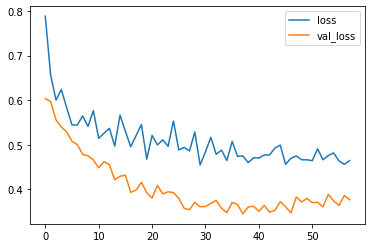

In [74]:
from keras.callbacks import EarlyStopping

callbacks = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True)

history = clf.fit(
    train_X, train_y,
    validation_data=(test_X, test_y),
    batch_size=64,
    epochs=400,
    verbose=0,
    callbacks=[callbacks],
    shuffle=True)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

In [75]:
predictions = clf.predict(X_test)

14/14 [==============================] - 0s 2ms/step


In [76]:
predictions

array([[0.12412061],
       [0.49391156],
       [0.04930409],
       [0.0912594 ],
       [0.49366564],
       [0.09065255],
       [0.73898095],
       [0.0948392 ],
       [0.79723495],
       [0.1051609 ],
       [0.09063628],
       [0.18766467],
       [0.99115914],
       [0.10739308],
       [0.96648127],
       [0.88707364],
       [0.13890527],
       [0.15971784],
       [0.39133   ],
       [0.6313993 ],
       [0.1630697 ],
       [0.18605536],
       [0.965978  ],
       [0.16366065],
       [0.99402475],
       [0.09497789],
       [0.9894198 ],
       [0.15221806],
       [0.24900098],
       [0.22207187],
       [0.11767107],
       [0.09555107],
       [0.4410138 ],
       [0.4480812 ],
       [0.3546911 ],
       [0.17469525],
       [0.4267259 ],
       [0.46078998],
       [0.09237389],
       [0.15370518],
       [0.12011012],
       [0.2788501 ],
       [0.09183663],
       [0.8313401 ],
       [0.9614446 ],
       [0.09119145],
       [0.32022983],
       [0.180

In [77]:
submission = pd.DataFrame()
submission['PassengerId'] = test_df['PassengerId']
submission['Survived'] = pd.DataFrame(predictions.round())
submission['Survived'] = submission['Survived'].apply(int)
submission.to_csv('nn_seven_try.csv', index=False)

In [78]:
submission['Survived'].sum()

135